# Creation of index with percentage of stocks above the 50-day exponential moving average

In this notebook we present a basic method to calculate the percentage of a stock index constituents whose prices are above the 50 day exponential moving average (50EMA).

The output is similar to the [MMTH](https://www.tradingview.com/symbols/INDEX-MMTH/) or the [NDXA50R](https://stockcharts.com/freecharts/gallery.html?$ndxa50r).

<img src='https://i.imgur.com/0xBvCMX.png'>

(image source: [macrovar.com](https://macrovar.com/united-states/nasdaq-100-percent-of-stocks-above-50-day-ma-ndxa50r/))

**Process overview:**

1.   Download stock price data for the desired period from YAHOO! Finance.
2.   Calculate the 50-day EMA for each day and each ticker. 
3.   Generate the chart.

For this example we work with the [Athex Composite Share Price index](https://www.athexgroup.gr/index-profile/-/select-index/17) (BBG ASE:IND).

The code can be reused to estimate an "index" using other index constituents or even a custom basket of securities.

**Changelog**

09OCT2022:

*    Index constituents list updated as follows:
    *    Removed `BYTE`, added `LOULIS` per ATHEX [press release](https://www.athexgroup.gr/el/web/guest/index-information-announcements/-/asset_publisher/1D6QWK7ezRVo/content/allages-stous-deiktes-tes-agoras-metoch-6?controlPanelCategory=portlet_101_INSTANCE_1D6QWK7ezRVo&redirect=https%3A%2F%2Fwww.athexgroup.gr%2Fel%2Fweb%2Fguest%2Findex-information-announcements%3Fp_p_id%3D101_INSTANCE_1D6QWK7ezRVo%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26controlPanelCategory%3Dportlet_101_INSTANCE_1D6QWK7ezRVo%26_101_INSTANCE_1D6QWK7ezRVo_) of 22/09/2022.
    *    Removed `EUPIC`, added `INTERCO`, per ATHEX [press release](https://www.athexgroup.gr/el/web/guest/index-information-announcements/-/asset_publisher/1D6QWK7ezRVo/content/allages-stous-deiktes-tes-agoras-metoch-5?controlPanelCategory=portlet_101_INSTANCE_1D6QWK7ezRVo&redirect=https%3A%2F%2Fwww.athexgroup.gr%2Fel%2Fweb%2Fguest%2Findex-information-announcements%3Fp_p_id%3D101_INSTANCE_1D6QWK7ezRVo%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26controlPanelCategory%3Dportlet_101_INSTANCE_1D6QWK7ezRVo%26_101_INSTANCE_1D6QWK7ezRVo_) of 03/08/2022.
*   Added code to download the ATHEX composite close prices.
*   Updated graph to include the ATHEX composite close price, for comparison purposes.




## Install / import libraries

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
import datetime

# to download the index data
import requests
from bs4 import BeautifulSoup

# to generate the plotly diagram
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")

## Generate dataset
A list of the current constituents of the ATHEX Composite Index can be found [here](https://www.athexgroup.gr/web/guest/index-composition/-/select-index/17).

### Download stock prices

In [3]:
# list of ticker names composing the Athens Stock Exchange General Index (BBG: ASE:IND). The keys are the greek symbols and the values are the corresponding symbols in YAHOO! Finance.
ATGSTONKS = {'ΑΛΦΑ':'ALPHA.AT',
             'ΕΤΕ':'ETE.AT',
             'ΕΥΡΩΒ':'EUROB.AT',
             'ΠΕΙΡ':'TPEIR.AT',
             'ΑΛΜΥ':'ALMY.AT',
             'ΕΛΣΤΡ':'ELSTR.AT',
             'ΕΛΧΑ':'ELHA.AT',
             'TITC':'TITC.AT',
             'ΑΒΑΞ':'AVAX.AT',
             'ΓΕΚΤΕΡΝΑ':'GEKTERNA.AT',
             'ΕΛΛΑΚΤΩΡ':'ELLAKTOR.AT',
             'ΙΚΤΙΝ':'IKTIN.AT',
             'ΙΝΚΑΤ':'INKAT.AT',
             'ΜΠΕΛΑ':'BELA.AT',
             'ΟΛΥΜΠ':'OLYMP.AT',
             'ΟΤΟΕΛ':'OTOEL.AT',
             'ΕΛΠΕ':'ELPE.AT',
             'ΜΟΗ':'MOH.AT',
             'ΕΧΑΕ':'EXAE.AT',
             'ΜΙΓ':'MIG.AT',
             'ΕΕΕ':'EEE.AT',
             'ΚΡΙ':'KRI.AT',
             'ΙΑΤΡ':'IATR.AT',
             'CENER':'CENER.AT',
             'ΒΙΟ':'VIO.AT',
             'ΕΛΤΟΝ':'ELTON.AT',
             'ΜΥΤΙΛ':'MYTIL.AT',
             'ΟΛΘ':'OLTH.AT',
             'ΟΛΠ':'PPA.AT',
             'ΠΕΤΡΟ':'PETRO.AT',
             'ΠΛΑΘ':'PLAT.AT',
             'ΠΛΑΚΡ':'PLAKR.AT',
             'ΙΝΤΕΡΚΟ':'INTERCO.AT',
             'ΙΝΛΙΦ':'INLIF.AT',
             'ΠΑΠ':'PAP.AT',
             'ΣΑΡ':'SAR.AT',
             'ΚΑΜΠ':'KAMP.AT',
             'ΚΕΚΡ':'KEKR.AT',
             'ΛΑΜΔΑ':'LAMDA.AT',
             'ΜΠΡΙΚ':'BRIQ.AT',
             'ΠΡΕΜΙΑ':'PREMIA.AT',
             'ΜΟΤΟ':'MOTO.AT',
             'ΠΛΑΙΣ':'PLAIS.AT',
             'ΦΡΛΚ':'FOYRK.AT',
             'ΛΟΥΛΗ':'KYLO.AT',
             'ΕΝΤΕΡ':'ENTER.AT',
             'ΕΠΣΙΛ':'EPSIL.AT',
             'ΙΝΤΕΚ':'INTEK.AT',
             'ΚΟΥΕΣ':'QUEST.AT',
             'ΠΡΟΦ':'PROF.AT',
             'ΙΝΤΚΑ':'INTRK.AT',
             'ΟΤΕ':'HTO.AT',
             'ΣΠΕΙΣ':'SPACE.AT',
             'ΑΡΑΙΓ':'AEGN.AT',
             'ΟΠΑΠ':'OPAP.AT',
             'ΑΔΜΗΕ':'ADMIE.AT',
             'ΔΕΗ':'PPC.AT',
             'ΕΥΑΠΣ':'EYAPS.AT',
             'ΕΥΔΑΠ':'EYDAP.AT',
             'ΤΕΝΕΡΓ':'TENERGY.AT'}

In [4]:
# we are interested only in the closing price, we fetch the last three years worth of data (practially right before the COVID crash).
tickers = yf.Tickers(list(ATGSTONKS.values()))
stockData = tickers.download(period='3y',interval='1d', actions=True,auto_adjust=True)['Close']

[*********************100%***********************]  60 of 60 completed


In [5]:
# have a look at a sample of the stocks
stockData.tail(5)

,ADMIE.AT,AEGN.AT,ALMY.AT,ALPHA.AT,AVAX.AT,BELA.AT,BRIQ.AT,CENER.AT,EEE.AT,ELHA.AT,...,PPC.AT,PREMIA.AT,PROF.AT,QUEST.AT,SAR.AT,SPACE.AT,TENERGY.AT,TITC.AT,TPEIR.AT,VIO.AT
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-17,1.686,4.78,1.920,0.8986,0.740,13.82,1.900,2.650,22.799999,1.390,...,5.49,1.075,2.930,4.065,6.30,6.66,17.799999,11.12,1.150,3.580
2022-10-18,1.660,4.80,1.920,0.9210,0.740,13.82,1.890,2.670,22.540001,1.406,...,5.68,1.070,2.930,4.110,6.44,6.66,17.920000,11.24,1.202,3.650
2022-10-19,1.692,4.75,1.920,0.9000,0.734,13.73,1.885,2.650,22.320000,1.402,...,5.81,1.055,2.900,4.035,6.30,6.60,18.010000,11.28,1.193,3.660
2022-10-20,1.704,4.73,1.920,0.9200,0.738,13.75,1.890,2.725,22.230000,1.402,...,5.90,1.060,2.885,3.975,6.28,6.60,18.200001,11.36,1.220,3.670
2022-10-21,1.700,4.68,1.916,0.9178,0.729,13.61,1.880,2.800,22.010000,1.420,...,5.97,1.060,2.885,3.965,6.54,6.72,18.200001,11.38,1.239,3.695


### Download index prices

In [6]:
# get current url from web page
req = requests.get('https://www.capital.gr/finance/historycloses/γδ?page=1')
soup = BeautifulSoup(req.content, 'html.parser')

link = soup.find("a", class_="download buttonS2").attrs.get('href')

In [7]:
# get the data into a pd data frame
data = pd.read_csv('https://www.capital.gr' + link, skiprows = 1, decimal=",")  

# remove columns we are not using
del data['ΜΕΤ.%']
del data['Τζίρος']

# convert date to date format
data['Ημ/νία'] = pd.to_datetime(data['Ημ/νία'], format="%d/%m/%Y")

# rename columns to en
data.columns = ['date', 'close', 'open', 'high', 'low', 'volume']

# make date index
data.set_index('date', inplace = True)

# convert volume column from string to float
data['volume'] = data['volume'].str.replace(".","").astype(float)

# rearrange columns
data = data[['open', 'high', 'low', 'close', 'volume']]

# keep data from the earliest date for which we have sstock data and sort ascending
data = data[(data.index >= stockData.index.min().strftime("%d/%m/%Y"))].sort_index(ascending=True)

# check for missing values (this will be included in the QC section of the final pipeline for the daily ingested data along with the other quality checks)
print('checking for null values...')
print(data.isnull().sum())

# copy into a new data frame
atgdata = data.copy()

# view a sample
print(atgdata)

checking for null values...
open      0
high      0
low       0
close     0
volume    0
dtype: int64
              open    high     low   close      volume
date                                                  
2019-10-22  867.28  874.82  866.95  873.50  26959785.0
2019-10-23  872.74  873.47  866.71  873.13  23515175.0
2019-10-24  873.44  876.59  869.29  873.98  26920927.0
2019-10-25  871.50  873.09  864.22  872.30  17697160.0
2019-10-29  874.44  876.24  868.48  873.40  31056678.0
...            ...     ...     ...     ...         ...
2022-10-17  832.91  843.99  832.84  842.64  14873634.0
2022-10-18  846.83  851.87  845.79  851.04  21042301.0
2022-10-19  848.66  851.17  843.61  848.17  14931587.0
2022-10-20  846.26  854.80  843.33  854.80  14720135.0
2022-10-21  854.65  854.99  847.06  854.99  11844291.0

[742 rows x 5 columns]


## Process dataset

In [8]:
# stack to multi index
t = stockData.stack()

# rename 'value' column
t.name = 'Close'

# save series to data frame
t = t.to_frame()

# calculate ema 50
t2 = t.groupby(level=1).apply(lambda x: x.ewm(span=50).mean())

# merge dataframes
t3 = pd.merge(t, t2, left_index=True, right_index=True)

# unstack
t4 = t3.reset_index(level=[0,1])

# create bool column to store whether price is above ema50
comparison_column = np.where(t4["Close_y"] < t4["Close_x"], True, False)
t4["above"] = comparison_column

# delete "Close_y" and "Close_X" prices as we don't need them - they store the actual close price and the EMA50 price
del t4["Close_x"]
del t4["Close_y"]

t4.rename(columns= {'above':'stocks_percent_above_EMA50'}, inplace=True)

# group by date
t4 = t4.groupby('Date')['stocks_percent_above_EMA50'].mean()*100

# save series to data frame
t4 = t4.to_frame()

# keep data from 01/01/2020 and beyond
t4 = t4[t4.index > '2020-01-01']

# look at a sample of the result
t4.tail(10)

,stocks_percent_above_EMA50
Date,
2022-10-10,30.000000
2022-10-11,18.333333
2022-10-12,20.000000
2022-10-13,25.000000
2022-10-14,35.000000
2022-10-17,48.333333
2022-10-18,45.000000
2022-10-19,46.666667
2022-10-20,51.666667


In [9]:
# optionally export to xls
#t4.to_excel('stocksAbove50EMA.xlsx')

## Plot index

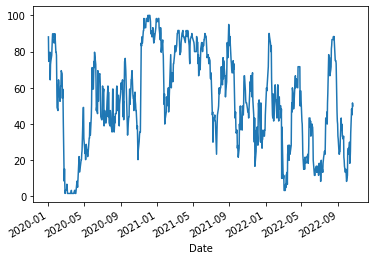

In [10]:
# basic plot of our index
t4['stocks_percent_above_EMA50'].plot()

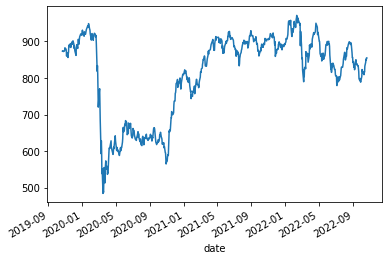

In [11]:
# basic plot of our athex composite
atgdata['close'].plot()

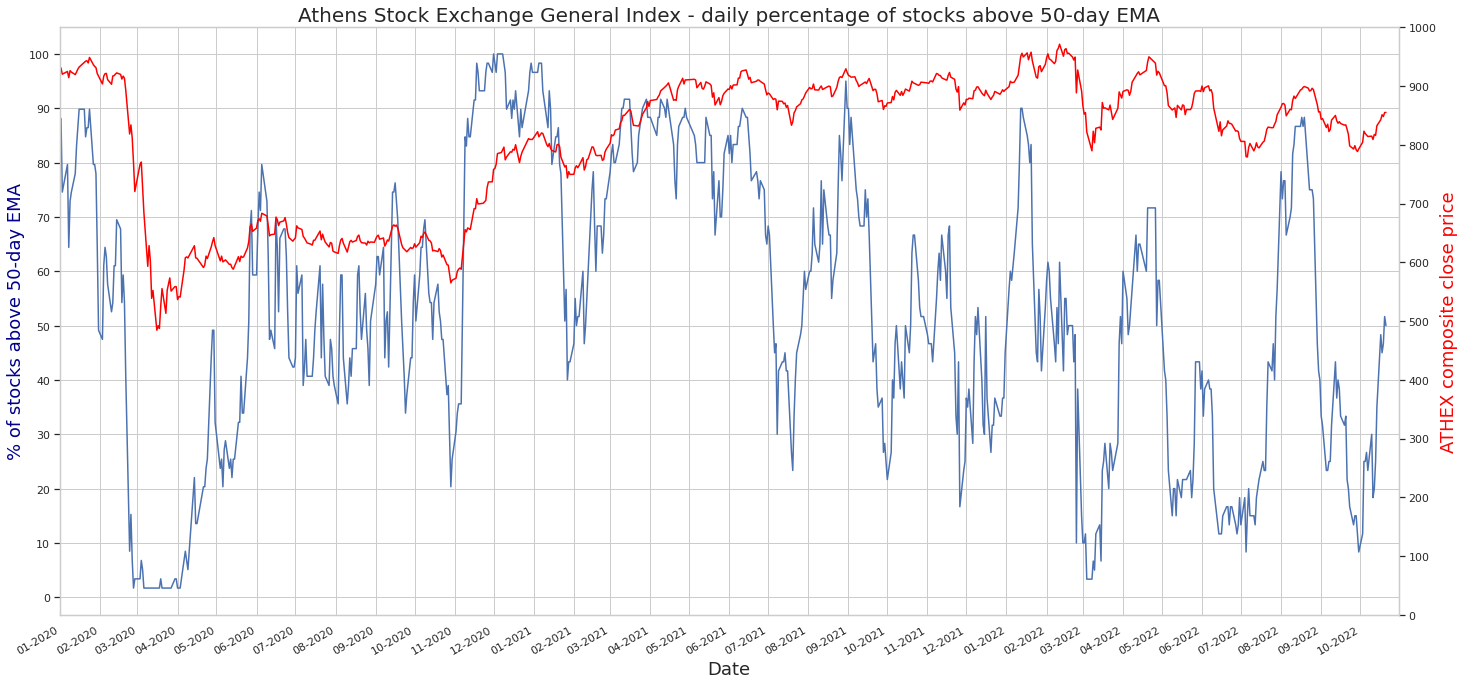

In [12]:
# ...or a bit nicer plot with seaborn
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(24, 12))

fig = sns.lineplot(data=t4, color = 'blue', legend = False)

ax2 = ax.twinx()

fig2 = sns.lineplot(data=atgdata['close'], ax=ax2, color = 'red')

fig.set_title("Athens Stock Exchange General Index - daily percentage of stocks above 50-day EMA", fontsize = 20)
ax.set_ylabel('% of stocks above 50-day EMA', fontsize = 18, color = 'darkblue')
ax2.set_ylabel('ATHEX composite close price', fontsize = 18, color = 'red')
fig.set_xlabel('Date', fontsize = 18)

ax.set_yticks(np.arange(0, 110, 10))
ax2.set_yticks(np.arange(0, 1100, 100))

ax2.grid(False)

ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2022, 10, 31)])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

plt.gcf().autofmt_xdate()

In [13]:
t4

,stocks_percent_above_EMA50
Date,
2020-01-02,88.135593
2020-01-03,74.576271
2020-01-07,79.661017
2020-01-08,64.406780
2020-01-09,72.881356
...,...
2022-10-17,48.333333
2022-10-18,45.000000
2022-10-19,46.666667


In [14]:
# plotly alternative

# calculate mean and standard deviations for the diagram
t4['mean'] = t4["stocks_percent_above_EMA50"].mean().round(2)
t4['+1σ'] = t4["stocks_percent_above_EMA50"].std().round(2)
t4['-1σ']  = t4["stocks_percent_above_EMA50"].mean().round(2) + t4["stocks_percent_above_EMA50"].std().round(2)

def generateChartTitle(df, text):
    title = text + "<br><sup>last update:" + str(df.index.date.max()) + "</sup>"
    return title

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=t4.index, y=t4["stocks_percent_above_EMA50"].round(2), name="Daily % of stocks above EMA50"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = atgdata.index, y = atgdata['close'], name="ATHEX composite close price",
               line=dict(color='firebrick', width=1)),
              secondary_y=True
              )

fig.add_trace(
    go.Scatter(x = [datetime.date(2020, 1, 1), datetime.date(2022, 12, 31)], y = t4['mean'], name = f"Mean: {t4['mean'].values[-1]}", mode='lines',
               line=dict(color='white', width=1, dash = 'dot')),
              secondary_y=False
              )

fig.add_trace(
    go.Scatter(x = [datetime.date(2020, 1, 1), datetime.date(2022, 12, 31)], y = t4['+1σ'], name = f"-1σ: {t4['+1σ'].values[-1]}", mode='lines',
               line=dict(color='green', width=2)),
              secondary_y=False
              )

fig.add_trace(
    go.Scatter(x = [datetime.date(2020, 1, 1), datetime.date(2022, 12, 31)], y = t4['-1σ'], name = f"+1σ: {t4['-1σ'].values[-1]}", mode='lines',
               line=dict(color='green', width=2)),
              secondary_y=False
              )

#fig.add_trace(go.Scatter(x=atgdata.index, 
#                         y=t4["stocks_percent_above_EMA50"].mean().round(2), line_dash="dot", 
#                         mode='lines', 
#                         line=dict(color='green', width=2, dash='dash'),
#                         name='2018-03-12'))

# Plot mean
# fig.add_hline(y= t4["stocks_percent_above_EMA50"].mean().round(2), line_dash="dot",
 #             annotation_text=f"Mean: {t4['stocks_percent_above_EMA50'].mean().round(2)}", 
  #            annotation_position="bottom left")
# Plot STDs
#fig.add_hline(y= t4["stocks_percent_above_EMA50"].std().round(2),
 #             annotation_text=f"+1SD: {t4['stocks_percent_above_EMA50'].std().round(2)}",
  #            line_color="green",
   #           annotation_position="top left")

#fig.add_hline(y= t4["stocks_percent_above_EMA50"].mean().round(2) + t4["stocks_percent_above_EMA50"].std().round(2),
 #             annotation_text=f"+1SD: {t4['stocks_percent_above_EMA50'].std().round(2)}",
  #            line_color="green",
   #           annotation_position="top left")

# Set x-axis title
fig.update_xaxes(
    title_text="Date",
    dtick="M1",
    tickformat="%b\n%Y",
    range = [datetime.date(2020, 1, 1), datetime.date(2022, 12, 31)])

# Set y-axes titles
fig.update_yaxes(title_text="<b>% above EMA50</b>", secondary_y=False, dtick=10)
fig.update_yaxes(title_text="<b>ATHEX Composite</b>", secondary_y=True, showgrid=True)

fig.update_layout(legend=dict(
    yanchor="auto",
    #y=-0.20,
    xanchor="auto",
    x=1
))

# Set theme, margin, and annotation in layout
fig.update_layout(
    template = "plotly_dark",
    width = 1800,
    height = 800,
    autosize = True,
    title = dict (
        {'text': generateChartTitle(atgdata,'<b>Athex Composite Share Price Index</b><br>Daily percentage of stocks above 50-day EMA'),
         'y':0.95,
         'x':0.06},
        font=dict(
            family="Arial",
            size=22)
        ),
    annotations=[
        dict(
            text="<b>Data sources:</b> YAHOO! Finance, capital.gr",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=-0.1),
                    dict(
            text="<b>Nexus-9</b>",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=-0.12)
    ]
)

# add marker for the last observation of the EMA50 plot
fig.add_scatter(x = [fig.data[0].x[-1]], y = [fig.data[0].y[-1]],
                mode = 'markers + text',
                marker = {'color':'red', 'size':10},
                showlegend = False,
                text = [fig.data[0].y[-1]],
                textposition='middle right',
                secondary_y=False)


# add marker for the last observation for the index plot
fig.add_scatter(x = [fig.data[1].x[-1]], y = [fig.data[1].y[-1]],
                mode = 'markers + text',
                marker = {'color':'red', 'size':10},
                showlegend = False,
                text = [fig.data[1].y[-1]],
                textposition='middle right',
                secondary_y=True)
fig.show()